# 1.라이브러리 불러오기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import random
import datetime

Instructions for updating:
non-resource variables are not supported in the long term


# 2. 데이터 불러오기

In [2]:
train_list = []

with open('train.txt') as f:
     for line in f:
        tmp = line.strip().split()
        #[0] = jpg 파일 이름
        # [1] = 인덱스 
        train_list.append([tmp[0],tmp[1]])

In [3]:
print(train_list[0][0])   # 파일 경로
print(train_list[0][1])   # 레이블
print(train_list[1][0])   # 파일 경로
print(train_list[1][1])   # 레이블
print(train_list[2][0])   # 파일 경로
print(train_list[2][1])   # 레이블

train\0.png
0
train\1.png
1
train\2.png
2


In [4]:
img_size = 28

def readimg(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #img = img.resize((img_size,img_size))
    img = cv2.resize(img, dsize=(img_size,img_size), interpolation=cv2.INTER_AREA)
    img = img.astype('float32') /255
    #img = np.reshape(img, [-1,10000])
    img = np.reshape(img, [img_size*img_size])
    
    
    return img

array([0.        , 0.        , 0.6313726 , 0.9411765 , 0.30980393,
       0.28627452, 0.19607843, 0.01568628, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.5372549 ,
       0.8666667 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07058824, 0.40784314, 0.9490196 , 0.7647059 ,
       0.00392157, 0.        , 0.        , 0.        , 0.02352941,
       0.7019608 , 1.        , 1.        , 1.        , 1.        ,
       0.9607843 , 0.7137255 , 0.47058824, 0.30980393, 0.39607844,
       0.65882355, 0.8117647 , 0.99607843, 0.99607843, 0.78039217,
       0.5803922 , 0.3137255 , 0.3137255 , 0.6666667 , 0.9647059 ,
       1.        , 1.        , 1.        , 0.62352943, 0.01176471,
       0.        , 0.        , 0.5058824 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

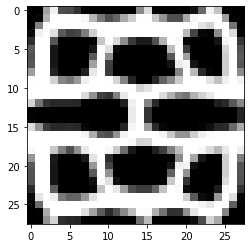

In [5]:
img1 = readimg(train_list[3][0])
#print(img1)
plt.imshow(img1.reshape(img_size,img_size),cmap='gray')
img1

# 3. next_batch 함수정의

In [6]:
def batch1():
    a = int(random.randint(0,len(train_list)-1))
    img1 = [readimg(train_list[a][0])]
    label1 = [a]
    
    for i in range(len(train_list)-1):
        a = int(random.randint(0,len(train_list)-1))
        
        img1 = img1
        img1 = np.concatenate([img1, [readimg(train_list[a][0])]])
        
        label1 = label1
        label1 = np.concatenate([label1,[a]])
    
    return img1, label1

In [7]:
def next_batch(train_list, batch_size):
    img1 , label1 = batch1()
    
    a = np.array(label1)
    label1 = np.zeros((a.size, len(train_list)))
    label1[np.arange(a.size),a] = 1

    
    img2 = img1[:batch_size]
    label2 = label1[:batch_size]    
    
    label2 = label2.astype('float32') 
    return img2, label2

In [8]:
batch_size = 2
img2, label2 =next_batch(train_list, batch_size)
label2

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# next_batch 출력 확인

batch_size = 12   # batch_size 조정 시 행, 열도 맞게 조절할 것
rows = 3
cols = 4
axes=[]
fig=plt.figure()

for a in range(rows*cols):
    b,c = next_batch(train_list, batch_size)   
    b= b[a].reshape(img_size,img_size)
    axes.append( fig.add_subplot(rows, cols, a+1) ) 
    print(c[a])
    plt.imshow(b, cmap='gray')
fig.tight_layout()    
plt.show()

# 4. 모델 정의

In [9]:
n_D_input = img_size*img_size
n_D_hidden = 256
n_D_output = 1

n_G_input = 128
n_G_hidden = 256
n_G_output = img_size*img_size

n_label = 24 

In [10]:
weights = {
    'G1' : tf.Variable(tf.random.normal([n_G_input + n_label, n_G_hidden], stddev = 0.01)),
    'G2' : tf.Variable(tf.random.normal([n_G_hidden, n_G_output], stddev = 0.01)),
    'D1' : tf.Variable(tf.random.normal([n_D_input + n_label, n_D_hidden], stddev = 0.01)),
    'D2' : tf.Variable(tf.random.normal([n_D_hidden, n_D_output], stddev = 0.01))
}

biases = {   
    'G1' : tf.Variable(tf.zeros([n_G_hidden])),
    'G2' : tf.Variable(tf.zeros([n_G_output])),
    'D1' : tf.Variable(tf.zeros([n_D_hidden])),
    'D2' : tf.Variable(tf.zeros([n_D_output]))
}

z = tf.placeholder(tf.float32, [None, n_G_input])
x = tf.placeholder(tf.float32, [None, n_D_input])
c = tf.placeholder(tf.float32, [None, n_label])           # GAN에서 추가되는 것

In [11]:
def generator(G_input, label, weights, biases):
    hidden = tf.nn.relu(tf.matmul(tf.concat([G_input, label], 1), weights['G1']) + biases['G1'])    
    output = tf.nn.sigmoid(tf.matmul(hidden, weights['G2']) + biases['G2'])
    return output

def discriminator(D_input, label, weights, biases):
    hidden = tf.nn.relu(tf.matmul(tf.concat([D_input, label], 1), weights['D1']) + biases['D1'])
    output = tf.nn.sigmoid(tf.matmul(hidden, weights['D2']) + biases['D2'])
    return output

def make_noise(batch_size, n_G_input):
    return np.random.normal(size = (batch_size, n_G_input))

n = make_noise(1,n_G_input)
print(n.shape)
print(n)

In [12]:
G_output = generator(z, c, weights, biases)
D_fake = discriminator(G_output, c, weights, biases)
D_real = discriminator(x, c, weights, biases)

D_loss = tf.reduce_mean(-tf.log(D_real)-tf.log(1 - D_fake))
G_loss = tf.reduce_mean(-tf.log(D_fake))

D_var_list = [weights['D1'], biases['D1'], weights['D2'], biases['D2']]
G_var_list = [weights['G1'], biases['G1'], weights['G2'], biases['G2']]

LR = 0.0002
D_optm = tf.train.AdamOptimizer(LR).minimize(D_loss, var_list = D_var_list)
G_optm = tf.train.AdamOptimizer(LR).minimize(G_loss, var_list = G_var_list)

Epoch: 0000 D_loss: 1.373 G_loss: 0.7125
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


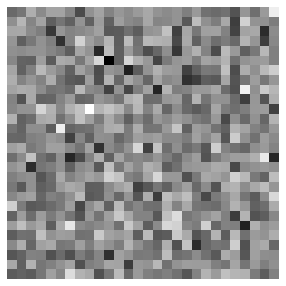

Epoch: 1000 D_loss: 0.6855 G_loss: 1.446
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


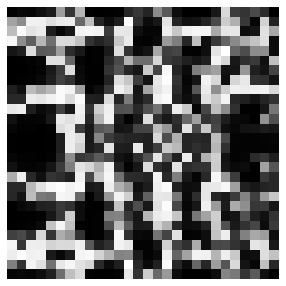

Epoch: 2000 D_loss: 0.3715 G_loss: 1.599
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


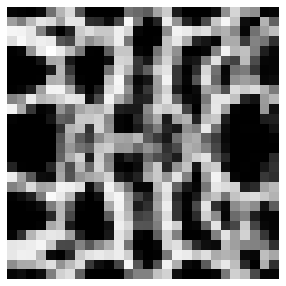

Epoch: 3000 D_loss: 0.6244 G_loss: 2.103
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


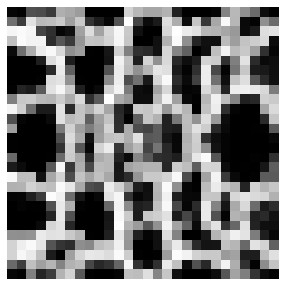

Epoch: 4000 D_loss: 0.0963 G_loss: 3.804
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


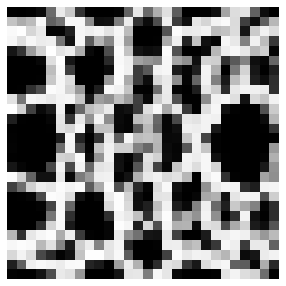

처리시간 :  0:01:44.444708


In [13]:
start = datetime.datetime.now()

total_epoch = 5000
batch_size = 12
#n_iter = int(len(train_list) / batch_size)
n_prt = 1000

sess = tf.Session()
saver = tf.train.Saver(tf.global_variables())
cpkt = tf.train.get_checkpoint_state('./CGAN_topoloy')
if cpkt and tf.train.checkpoint_exists(cpkt.model_checkpoint_path):
    saver.restore(sess, cpkt.model_checkpoint_path)
    print("Load sess")
else:
    sess.run(tf.global_variables_initializer())


    D_loss_record = []
    G_loss_record = []
    for epoch in range(total_epoch):
        (train_x, train_y) = next_batch(train_list,batch_size)
        #train_x = np.array(train_x)
        #train_y = np.array(train_y)
        noise = make_noise(batch_size, n_G_input)

        # discriminator and generator are separately trained 
        sess.run(D_optm, feed_dict = {x: train_x, z: noise, c: train_y})                 # Discriminator과 generator 각각 훈련
        sess.run(G_optm, feed_dict = {z: noise, c: train_y})                             # 안성정 측면 각각 균형을 맞추는 것이 중요하여 각각 훈련

        if epoch % n_prt == 0:
            D_loss_val = sess.run(D_loss, feed_dict = {x: train_x, z: noise, c: train_y})
            G_loss_val = sess.run(G_loss, feed_dict = {z: noise, c: train_y})
            D_loss_record.append(D_loss_val)
            G_loss_record.append(G_loss_val)
        
            print('Epoch:', '%04d' % epoch, 'D_loss: {:.4}'.format(D_loss_val), 'G_loss: {:.4}'.format(G_loss_val))
            
            plt.figure(figsize = (5,5))
            noise = make_noise(1, n_G_input)
          
            _, train_y = next_batch(train_list, 1)
           # train_y = np.array(train_y)
            print(train_y)
            G_img = sess.run(G_output, feed_dict = {z: noise, c: train_y})   
            plt.imshow(G_img.reshape(28,28), 'gray')
            plt.axis('off')
            plt.show()
            
            
            
end = datetime.datetime.now()
time = end - start
print("처리시간 : ", time)

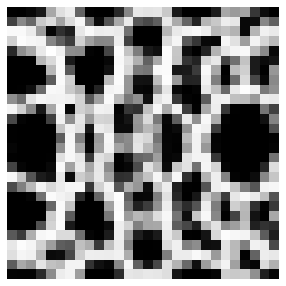

In [14]:
noise = make_noise(1, n_G_input)
G_img = sess.run(G_output, feed_dict = {z: noise, c: [[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]})

plt.figure(figsize = (5,5))
plt.imshow(G_img.reshape(img_size,img_size), 'gray')
plt.axis('off')

plt.show()